In [48]:
# SVM predictions on mouse data
import scanpy as sc
import numpy as np
import pickle

In [49]:
clf = pickle.load(open("svm_model_landscape.pickle", "rb"))

In [50]:
adata_pred = sc.read_h5ad('/home/chutianhao/R/Projects/snRNA_scRNA_hcc/project/svm/data/sc_mouse_all.h5ad')

In [51]:
adata_pred.obs.annotation.unique()

['T cells', 'NK cells', 'Monocyte-linage', 'Granulocytes', 'Cycling cells', 'B cells', 'Endothelial cells', 'Hepatocytes', 'Plasma cells', 'CAF']
Categories (10, object): ['B cells', 'CAF', 'Cycling cells', 'Endothelial cells', ..., 'Monocyte-linage', 'NK cells', 'Plasma cells', 'T cells']

In [52]:
adata_pred = adata_pred[adata_pred.obs.annotation.isin(["B cells", 
                                                        "CAF", 
                                                        "Endothelial cells", 
                                                        "Hepatocytes", 
                                                        "Monocyte-linage", 
                                                        "NK cells", 
                                                        "Granulocytes", 
                                                        "Plasma cells",
                                                        "T cells"])]

In [53]:
# make sure the mouse and human celltype match
adata_pred.obs['annotation'] = (
    adata_pred.obs["annotation"]
    .map(lambda x: {"Granulocytes": "Myeloid cells", "Monocyte-linage": "Myeloid cells", "NK cells": "T/NK", "T cells": "T/NK"}.get(x, x))
    .astype("category")
)

/tmp/ipykernel_1010/2099056529.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_pred.obs['annotation'] = (


In [54]:
adata_pred.obs.annotation.unique()

['T/NK', 'Myeloid cells', 'B cells', 'Endothelial cells', 'Hepatocytes', 'Plasma cells', 'CAF']
Categories (7, object): ['B cells', 'CAF', 'Endothelial cells', 'Hepatocytes', 'Myeloid cells', 'Plasma cells', 'T/NK']

In [55]:
adata_pred.obs[['nCount_RNA']].describe()

,nCount_RNA
count,53817.000000
mean,393.934667
std,886.173692
min,0.000000
25%,24.000000
50%,87.000000
75%,338.000000
max,18959.000000


In [56]:
adata_pred

AnnData object with n_obs × n_vars = 53817 × 300
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_id', 'mt_ratio', 'ribo_ratio', 'condition', 'RNA_snn_res.1', 'seurat_clusters', 'sc_leiden', 'annotation'
    var: 'name'

In [57]:
X = adata_pred.X.copy()
Y = adata_pred.obs.copy()

In [58]:
Y

,orig.ident,nCount_RNA,nFeature_RNA,sample_id,mt_ratio,ribo_ratio,condition,RNA_snn_res.1,seurat_clusters,sc_leiden,annotation
PT1_AAACCCAAGCCTCAGC-1,PT1,2.0,2,PT1,4.633854,25.354142,PT,0,0,3,T/NK
PT1_AAACCCAAGGAGAATG-1,PT1,4.0,2,PT1,4.281346,39.274792,PT,0,0,13,T/NK
PT1_AAACCCACAAGCTGTT-1,PT1,4.0,2,PT1,3.045603,33.762215,PT,5,5,6,T/NK
PT1_AAACCCACAGTAGAAT-1,PT1,5.0,5,PT1,3.472868,39.798450,PT,5,5,6,T/NK
PT1_AAACCCAGTAGCTGCC-1,PT1,57.0,12,PT1,0.872030,5.668193,PT,6,6,7,Myeloid cells
...,...,...,...,...,...,...,...,...,...,...,...
NT3_TTTGGTTCATTCGATG_2,NT3,487.0,59,NT3,0.864253,10.579645,NT,7,7,8,CAF
NT3_TTTGGTTGTGCATTTG_2,NT3,229.0,36,NT3,1.951827,9.219269,NT,7,7,8,CAF
NT3_TTTGGTTGTTGAAGTA_2,NT3,156.0,34,NT3,1.647346,7.321538,NT,7,7,8,CAF
NT3_TTTGGTTTCCGCAAAT_2,NT3,417.0,46,NT3,1.090492,9.699637,NT,7,7,8,CAF


In [59]:
X = X.toarray()
Y = Y.loc[:, 'annotation']

In [60]:
Y = Y.values.to_list()

In [61]:
# scale the data before training
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [62]:
Y_pred = clf.predict(X)

In [63]:
Y_proba = clf.predict_proba(X)

In [64]:
Y_pred = Y_pred.tolist()

In [65]:
# calculate the model precision, recall and F1-score
from sklearn import metrics
print(metrics.classification_report(Y, Y_pred, digits=3))

                   precision    recall  f1-score   support

          B cells      0.066     0.354     0.111      2439
              CAF      0.631     0.997     0.773      2811
Endothelial cells      0.849     0.763     0.804      6318
      Hepatocytes      0.547     0.975     0.700      8337
    Myeloid cells      0.976     0.555     0.708     23442
     Plasma cells      0.088     0.994     0.162       174
             T/NK      0.456     0.019     0.036     10296

         accuracy                          0.557     53817
        macro avg      0.516     0.665     0.471     53817
     weighted avg      0.733     0.557     0.564     53817



In [66]:
# convert Y_proba array to pandas dataframe, and save as a csv file
import pandas as pd

In [67]:
Y_proba

array([[8.12406627e-01, 1.19256491e-02, 3.22756198e-02, ...,
        1.99793990e-02, 1.65391695e-02, 9.59040849e-02],
       [7.02694843e-01, 2.25861810e-02, 1.11871295e-01, ...,
        1.78877939e-02, 4.97348426e-02, 6.82400806e-02],
       [7.54690187e-01, 1.22551649e-02, 6.39247183e-02, ...,
        2.60762591e-02, 1.85987482e-02, 1.07618435e-01],
       ...,
       [3.83820953e-05, 9.80218577e-01, 8.56056158e-03, ...,
        1.00588403e-03, 6.43814846e-04, 4.88792980e-04],
       [1.63562134e-06, 9.97005225e-01, 2.45575869e-03, ...,
        6.92279799e-05, 6.02670060e-05, 1.79942251e-05],
       [6.33200182e-09, 9.99821954e-01, 1.34694934e-04, ...,
        4.06049814e-06, 1.88416643e-05, 2.95159982e-06]])

In [69]:
Y_df = pd.DataFrame(data=Y_proba, 
                    columns=["B cells", 
                             "CAF", 
                             "Endothelial cells", 
                             "Hepatocytes", 
                             "Myeloid cells", 
                             "Plasma cells",
                             "T/NK"])

In [70]:
Y_df['annotation'] = Y

In [71]:
Y_df['prediction'] = Y_pred

In [72]:
Y_df.to_csv('data/cell_prob_landscape.csv')

In [42]:
# re-predict the TREM2+ signature to the whole mouse dataset

In [44]:
adata_mouse = sc.read_h5ad('data/mye_mouse_train.h5ad')

In [45]:
X = adata_mouse.X.copy().toarray()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [46]:
Y_pred = clf.predict(X)

In [47]:
Y_proba = clf.predict_proba(X)

In [48]:
Y_proba = pd.DataFrame(data=Y_proba, 
                       columns=['Classical monocyte', 
                             'FOLR2+ TAM', 
                             'Inflam-TAM', 
                             'Kupffer cell', 
                             'Nonclassical monocyte', 
                             'TREM2+ LAM'])

In [49]:
# import the original dataset to embbed the proba on original umap plot

In [145]:
adata = sc.read_h5ad("/home/chutianhao/python/snRNA_scRNA_hcc/scvi/integration_mouse_myeloid/adata_filtered.h5ad")

In [146]:
sc.settings.verbosity = 3
sc.set_figure_params(dpi=150, frameon=True, color_map='viridis_r', dpi_save=600)
palette_d = ['#378C4F', '#6DB6FFFF', '#B6DBFFFF', '#E2A7CC', '#924900FF','#F5CDCD', '#D9579B', '#7BBC5E',  '#7464AA', '#006DDBFF', '#A59ACB'] # user defined discrete colors

/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


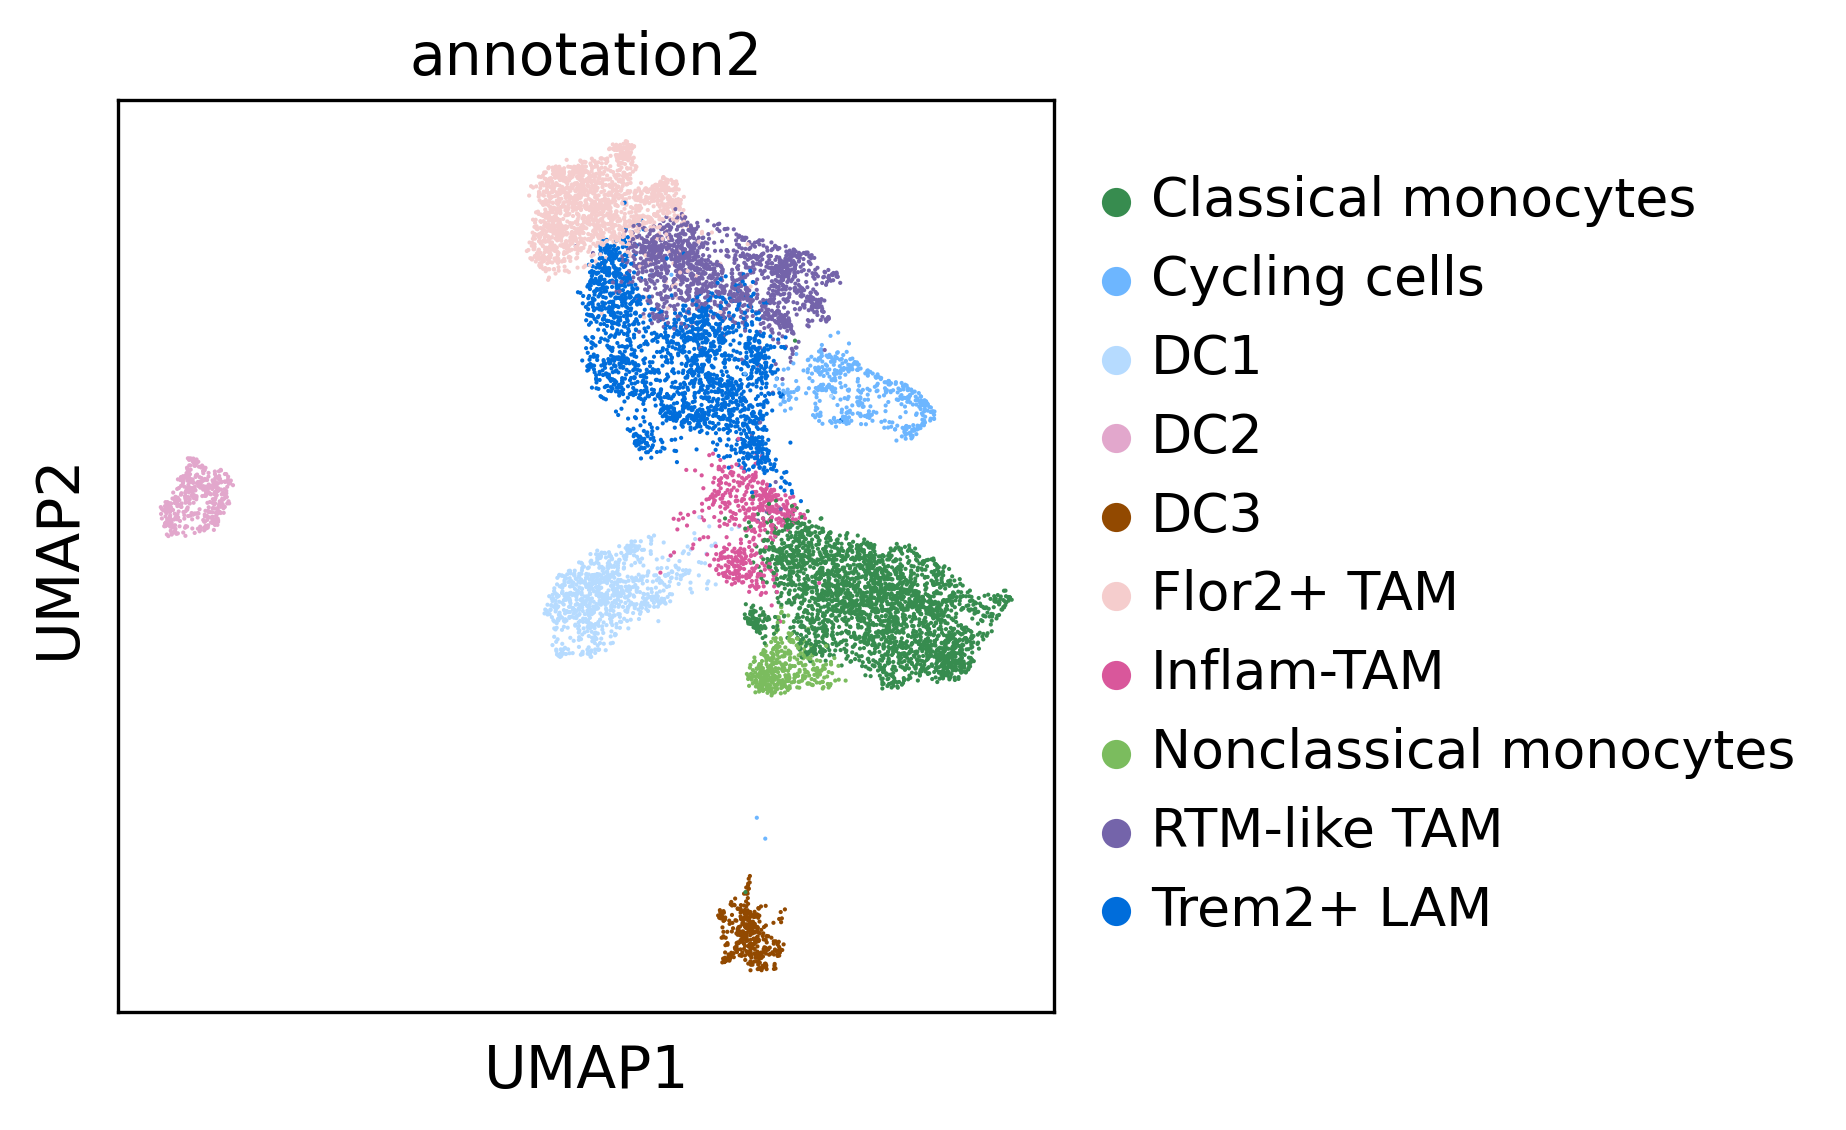

In [147]:
sc.pl.umap(adata, color = 'annotation2', s=4,)

In [150]:
adata.obs['Trem2_proba'] = Y_proba['TREM2+ LAM'].values.tolist()
adata.obs['Folr2_proba'] = Y_proba['FOLR2+ TAM'].values.tolist()
adata.obs['RTM_proba'] = Y_proba['Kupffer cell'].values.tolist()
adata.obs['Inflam_proba'] = Y_proba['Inflam-TAM'].values.tolist()
adata.obs['clas_mono_proba'] = Y_proba['Classical monocyte'].values.tolist()
adata.obs['nocl_mono_proba'] = Y_proba['Nonclassical monocyte'].values.tolist()

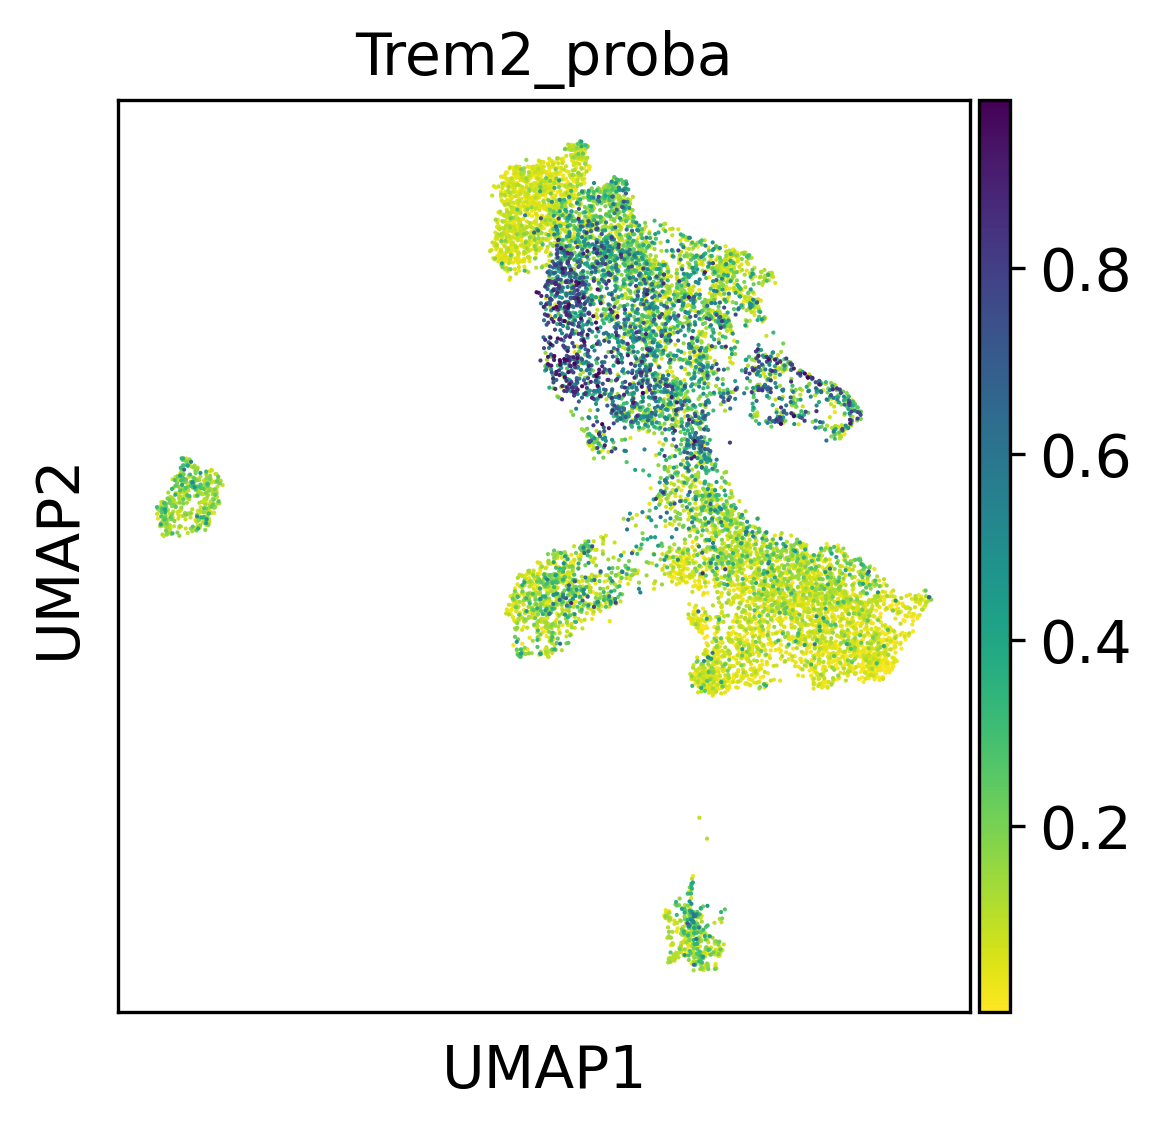

In [154]:
sc.pl.umap(adata, color='Trem2_proba', s=4, save='Trem2_proba_umap.pdf')

In [161]:
# save this new anndata obj
adata.write("adata_proba_added.h5ad")